In [42]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [43]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [44]:
from masa_utils import PsuedoLog
from masa_utils import Debye_sum_res_f
from masa_utils import InducedPolarizationSimulation as IP_np
from masa_utils import Optimization as opt_np
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton_res_f, ColeCole_f, Pelton_debye_f
from masa_utils_pytorch import Optimization

In [45]:
#pelton model
parm_true = torch.tensor([np.log(0.2), 0.50, np.log(0.1), 0.2], dtype=torch.float32) #, requires_grad=False)
# cole model
parm_init = torch.tensor([np.log(10), 0.0, np.log(0.01), 0.4], dtype=torch.float32, requires_grad=True) #, requires_grad=False)


# Invert cole cole model from pelton model

In [46]:
nfreq = 71
freqstrt_log = -2
freqend_log = 5
freq = np.logspace(-2, 5, nfreq)

# freqend_log = torch.log10(torch.tensor(1e5)).item()
# freqstrt_log = torch.log10(torch.tensor(1e-2)).item()
# freq = torch.logspace(freqstrt_log, freqend_log, nfreq) 

freq_plot = freq
print(freq.shape)
print(freq)

(71,)
[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.

In [47]:
IP_model = Pelton_res_f(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model)

# sim.J(parm_pelton)

In [48]:
dobs_clean=sim.dpred(parm_true).detach()
f_abs = abs(IP_model.f(parm_true)).detach().numpy()
print(f_abs.max(),f_abs.min())

0.1739444 0.10957104


In [49]:
# relative_error = torch.tensor(0.01)
# noise_floor = torch.tensor(0.00)
relative_error = torch.tensor(0)

noise_floor = torch.tensor(f_abs.max() * 0.01)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )
# dobs = dobs_clean

In [50]:
print(dobs)

tensor([ 0.1741,  0.1729,  0.1729,  0.1723,  0.1705,  0.1696,  0.1697,  0.1671,
         0.1672,  0.1657,  0.1639,  0.1633,  0.1630,  0.1618,  0.1601,  0.1582,
         0.1577,  0.1573,  0.1550,  0.1546,  0.1529,  0.1526,  0.1511,  0.1502,
         0.1482,  0.1466,  0.1456,  0.1458,  0.1432,  0.1430,  0.1415,  0.1403,
         0.1386,  0.1374,  0.1366,  0.1358,  0.1342,  0.1335,  0.1326,  0.1313,
         0.1314,  0.1297,  0.1283,  0.1274,  0.1272,  0.1258,  0.1258,  0.1241,
         0.1228,  0.1229,  0.1218,  0.1211,  0.1212,  0.1194,  0.1188,  0.1185,
         0.1184,  0.1178,  0.1157,  0.1161,  0.1154,  0.1143,  0.1133,  0.1138,
         0.1126,  0.1129,  0.1114,  0.1109,  0.1120,  0.1109,  0.1112, -0.0055,
        -0.0061, -0.0063, -0.0059, -0.0052, -0.0064, -0.0065, -0.0062, -0.0057,
        -0.0065, -0.0073, -0.0068, -0.0069, -0.0064, -0.0072, -0.0063, -0.0061,
        -0.0071, -0.0062, -0.0074, -0.0068, -0.0074, -0.0076, -0.0078, -0.0078,
        -0.0077, -0.0072, -0.0068, -0.00

In [51]:
IP_model = ColeCole_f(freq=freq, res=True)
sim = InducedPolarizationSimulation(ip_model=IP_model)

In [52]:
dinit = sim.dpred(parm_init)
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(len(parm_init))

In [53]:
print(opt.Wd)

tensor([[574.8964,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000, 574.8964,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000, 574.8964,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ..., 574.8964,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000, 574.8964,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000, 574.8964]])


In [54]:
beta0 = opt.BetaEstimate_byEig(mvec=parm_init, update_Wsen=True)
print(beta0)

tensor(290069.4688)


In [55]:
niter = 30
mpred = opt.GaussNewton(stol=1e-3,
         coolingFactor=2.0, coolingRate=2,mu=-0.1,
    mvec_init=parm_init,niter=niter,beta0=beta0, update_Wsen=True,
    )


  1, beta:2.9e+05, step:1.0e+00, gradient:1.1e+05,  f:1.6e+04
  2, beta:2.9e+05, step:5.0e-01, gradient:3.4e+04,  f:4.3e+03
  3, beta:1.5e+05, step:9.8e-04, gradient:1.3e+05,  f:2.1e+04
  4, beta:1.5e+05, step:1.0e+00, gradient:1.3e+05,  f:8.1e+03
  5, beta:7.3e+04, step:1.0e+00, gradient:4.4e+04,  f:3.9e+03
  6, beta:7.3e+04, step:1.0e+00, gradient:1.9e+04,  f:3.0e+03
  7, beta:3.6e+04, step:1.0e+00, gradient:7.3e+03,  f:2.1e+03
  8, beta:3.6e+04, step:1.0e+00, gradient:3.5e+03,  f:1.9e+03
  9, beta:1.8e+04, step:1.0e+00, gradient:5.3e+03,  f:1.2e+03
 10, beta:1.8e+04, step:1.0e+00, gradient:4.1e+03,  f:1.1e+03
 11, beta:9.1e+03, step:1.0e+00, gradient:3.5e+03,  f:6.6e+02
 12, beta:9.1e+03, step:1.0e+00, gradient:3.8e+03,  f:5.9e+02
 13, beta:4.5e+03, step:1.0e+00, gradient:2.2e+03,  f:3.6e+02
 14, beta:4.5e+03, step:1.0e+00, gradient:2.8e+03,  f:3.3e+02
 15, beta:2.3e+03, step:1.0e+00, gradient:1.3e+03,  f:2.0e+02
 16, beta:2.3e+03, step:1.0e+00, gradient:1.8e+03,  f:1.8e+02
 17, bet

In [56]:

np_mvec_prg = opt.mvec_prg
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = opt.dpred(mpred)

In [57]:
print(f"initial :{np.exp(np_mvec_init[0]):.3e}, {np_mvec_init[1]:3f}, {np.exp(np_mvec_init[2]):.3e}, {np_mvec_init[3]:.3f}")
print(f"est     :{np.exp(np_mvec_est[0]):.3e}, { np_mvec_est[1]:3f}, { np.exp(np_mvec_est[2]):.3e}, { np_mvec_est[3]:.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.3e}, {np_mvec_true[1]:3f}, {np.exp(np_mvec_true[2]):.3e}, {np_mvec_true[3]:.3f}")


initial :1.000e+01, 0.000000, 1.000e-02, 0.400
est     :9.602e+00, 0.462077, 4.376e-03, 0.225
true    :2.000e-01, 0.500000, 1.000e-01, 0.200


In [58]:
nwindow = len(freq)
dest_real = dest[:nwindow].detach().numpy().flatten()
dest_imag = dest[nwindow:].detach().numpy().flatten()
dest_abs = np.abs(dest_real+ 1.0j*dest_imag)
dest_phase = np.angle(dest_real+ 1.0j*dest_imag, deg=True) # -1000*np.arctan2(dest_imag, dest_real)
dobs_real = dobs[:nwindow].detach().numpy().flatten()
dobs_imag = dobs[nwindow:].detach().numpy().flatten()
dobs_abs = np.abs(dobs_real+ 1.0j*dobs_imag)
dobs_phase = np.angle(dobs_real+ 1.0j*dobs_imag, deg=True) 
dinit_real = dinit[:nwindow].detach().numpy().flatten()
dinit_imag = dinit[nwindow:].detach().numpy().flatten()
dinit_abs = np.abs(dinit_real+ 1.0j*dinit_imag)
dinit_phase =  np.angle(dinit_real+ 1.0j*dinit_imag, deg=True)

windows_plot = freq_plot

In [59]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(freq_plot[freq_plot>eps].min())),
            linScalex=0.2)


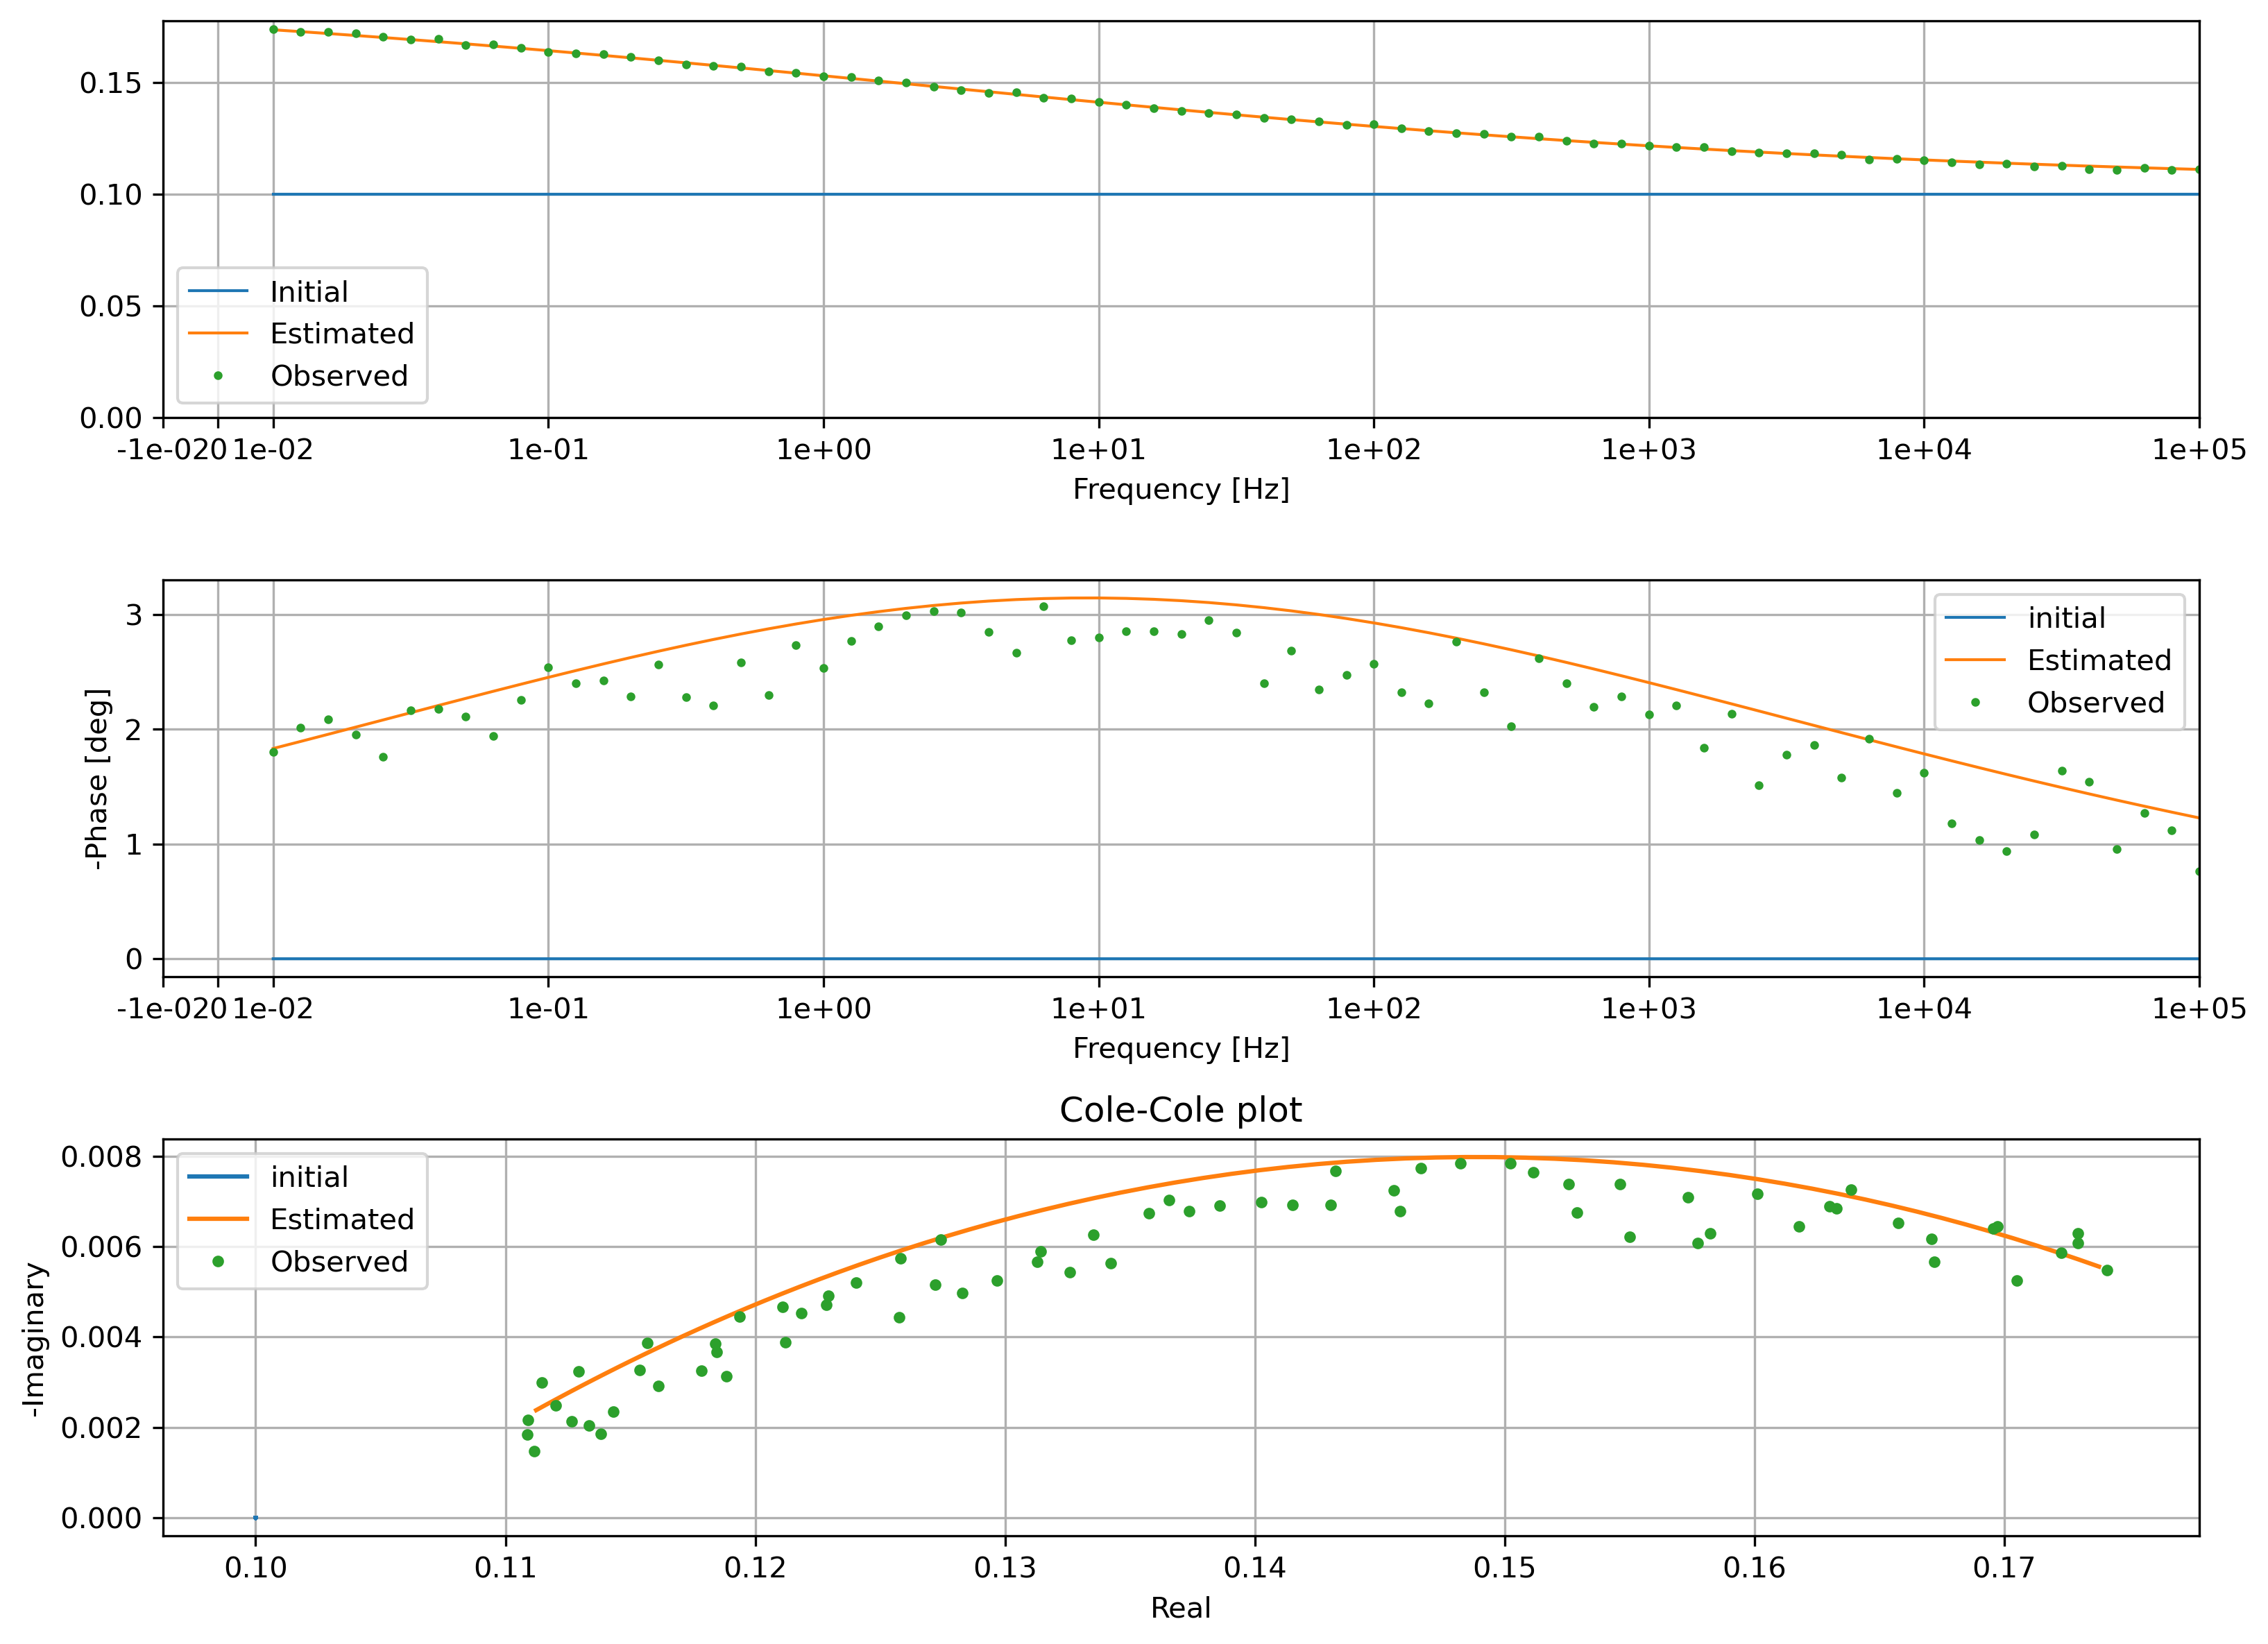

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(11, 8),dpi=300)

ax[0] = PL_pelton.semiplx(x=freq_plot, y=dinit_real, ax=ax[0], yscale_log=False,
                          color = "C0",label="Initial")
ax[0] = PL_pelton.semiplx(x=freq_plot, y=dest_real, ax=ax[0], yscale_log=False,
                            color = "C1",label="Estimated")
ax[0] = PL_pelton.semiplx(x=freq_plot, y=dobs_real, ax=ax[0], yscale_log=False,
            color = "C2",linestyle="",markersize=4.0, marker=".",label="Observed")
ax[0].set_ylim(bottom=0)
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_pelton.semiplx(x=freq_plot, y=-dinit_phase, ax=ax[1], yscale_log=False,
                                color = "C0",label="initial")
ax[1] = PL_pelton.semiplx(x=freq_plot, y=-dest_phase, ax=ax[1], yscale_log=False,
                                color = "C1",label="Estimated")
ax[1] = PL_pelton.semiplx(x=freq_plot, y=-dobs_phase, ax=ax[1], yscale_log=False,
            color = "C2",linestyle="",markersize=4.0, marker=".",label="Observed")
PL_pelton.pl_axes_x(ax=ax[1])
ax[2].plot(dinit_real, -dinit_imag, color="C0", label="initial")
ax[2].plot(dest_real, -dest_imag, color="C1", label="Estimated")
ax[2].plot(dobs_real, -dobs_imag, color="C2", linestyle="", marker=".", label="Observed")

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[1].set_ylabel('-Phase [deg]')
ax[2].set_title("Cole-Cole plot")
ax[2].set_xlabel("Real")
ax[2].set_ylabel("-Imaginary")
plt.tight_layout()

#  Lineary Weighted Debye model

In [61]:
ntau=5
taus = np.logspace(-4,0,ntau)
print(taus)

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]


In [62]:
IP_model = Pelton_debye_f(freq=freq, ntau=ntau, taus=taus)
# IP_model = Pelton_debye_f(freq=freq, ntau=ntau)

sim = InducedPolarizationSimulation(ip_model=IP_model)

In [63]:
parm_init = torch.tensor(
    torch.cat([torch.log(torch.tensor([0.3])), torch.zeros(ntau)]),
    dtype=torch.float32,
    requires_grad=True
) #, requires_grad=False)
# parm_init = torch.tensor(np.r_[np.log(0.3), np.zeros(ntau), np.log(taus)], 
#                 dtype=torch.float32, requires_grad=True) #, requires_grad=False)
mvec_init = parm_init.detach().numpy()
dinit = sim.dpred(parm_init)

C:\Users\81805\AppData\Local\Temp\ipykernel_12528\3054815225.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parm_init = torch.tensor(


In [64]:
print(parm_init)

tensor([-1.2040,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       requires_grad=True)


In [65]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))

In [66]:
beta0 = opt.BetaEstimate_byEig(mvec=parm_init, update_Wsen=True)
print(beta0)

tensor(6535747.5000)


In [67]:
niter = 50
stol=1e-3
coolingFactor = 2.0
coolingRate = 2
mu=-0.1
mpred = opt.GaussNewton(stol=stol,
    coolingFactor=coolingFactor, coolingRate=2,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0, update_Wsen=True,
    )

  1, beta:6.5e+06, step:1.0e+00, gradient:1.9e+06,  f:1.5e+05
  2, beta:6.5e+06, step:9.8e-04, gradient:1.2e+05,  f:1.6e+05
  3, beta:3.3e+06, step:1.0e+00, gradient:3.4e+05,  f:1.1e+05
  4, beta:3.3e+06, step:1.0e+00, gradient:1.4e+04,  f:1.1e+05
  5, beta:1.6e+06, step:1.0e+00, gradient:2.7e+05,  f:7.7e+04
  6, beta:1.6e+06, step:1.0e+00, gradient:7.4e+03,  f:7.5e+04
  7, beta:8.2e+05, step:1.0e+00, gradient:1.7e+05,  f:4.8e+04
  8, beta:8.2e+05, step:1.0e+00, gradient:5.3e+03,  f:4.8e+04
  9, beta:4.1e+05, step:1.0e+00, gradient:1.0e+05,  f:2.9e+04
 10, beta:4.1e+05, step:1.0e+00, gradient:5.1e+03,  f:2.9e+04
 11, beta:2.0e+05, step:1.0e+00, gradient:5.8e+04,  f:1.7e+04
 12, beta:2.0e+05, step:9.8e-04, gradient:4.2e+03,  f:1.7e+04
 13, beta:1.0e+05, step:1.0e+00, gradient:2.8e+04,  f:9.8e+03
 14, beta:1.0e+05, step:9.8e-04, gradient:2.4e+03,  f:1.0e+04
 15, beta:5.1e+04, step:1.0e+00, gradient:1.6e+04,  f:5.5e+03
 16, beta:5.1e+04, step:9.8e-04, gradient:1.4e+03,  f:5.6e+03
 17, bet

In [68]:
np_mvec_prg = opt.mvec_prg
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = opt.dpred(mpred)
mvec_pred = mpred.detach().numpy()
#taus = np.exp(mvec_pred[1+ntau:])

In [69]:
print(f"initial :{np.exp(np_mvec_init[0]):.3e}, {np_mvec_init[1].sum():3f}")
print(f"est     :{np.exp(np_mvec_est[0]):.3e}, { np_mvec_est[1:].sum():3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.3e}, {np_mvec_true[1]:3f}, {np.exp(np_mvec_true[2]):.3e}, {np_mvec_true[3]:.3f}")


initial :3.000e-01, 0.000000
est     :1.707e-01, 0.331547
true    :2.000e-01, 0.500000, 1.000e-01, 0.200


In [70]:
nwindow = len(freq)
dest_real = dest[:nwindow].detach().numpy().flatten()
dest_imag = dest[nwindow:].detach().numpy().flatten()
dest_abs = np.abs(dest_real+ 1.0j*dest_imag)
dest_phase = np.angle(dest_real+ 1.0j*dest_imag, deg=True) # -1000*np.arctan2(dest_imag, dest_real)
dobs_real = dobs[:nwindow].detach().numpy().flatten()
dobs_imag = dobs[nwindow:].detach().numpy().flatten()
dobs_abs = np.abs(dobs_real+ 1.0j*dobs_imag)
dobs_phase = np.angle(dobs_real+ 1.0j*dobs_imag, deg=True) 
dinit_real = dinit[:nwindow].detach().numpy().flatten()
dinit_imag = dinit[nwindow:].detach().numpy().flatten()
dinit_abs = np.abs(dinit_real+ 1.0j*dinit_imag)
dinit_phase =  np.angle(dinit_real+ 1.0j*dinit_imag, deg=True)


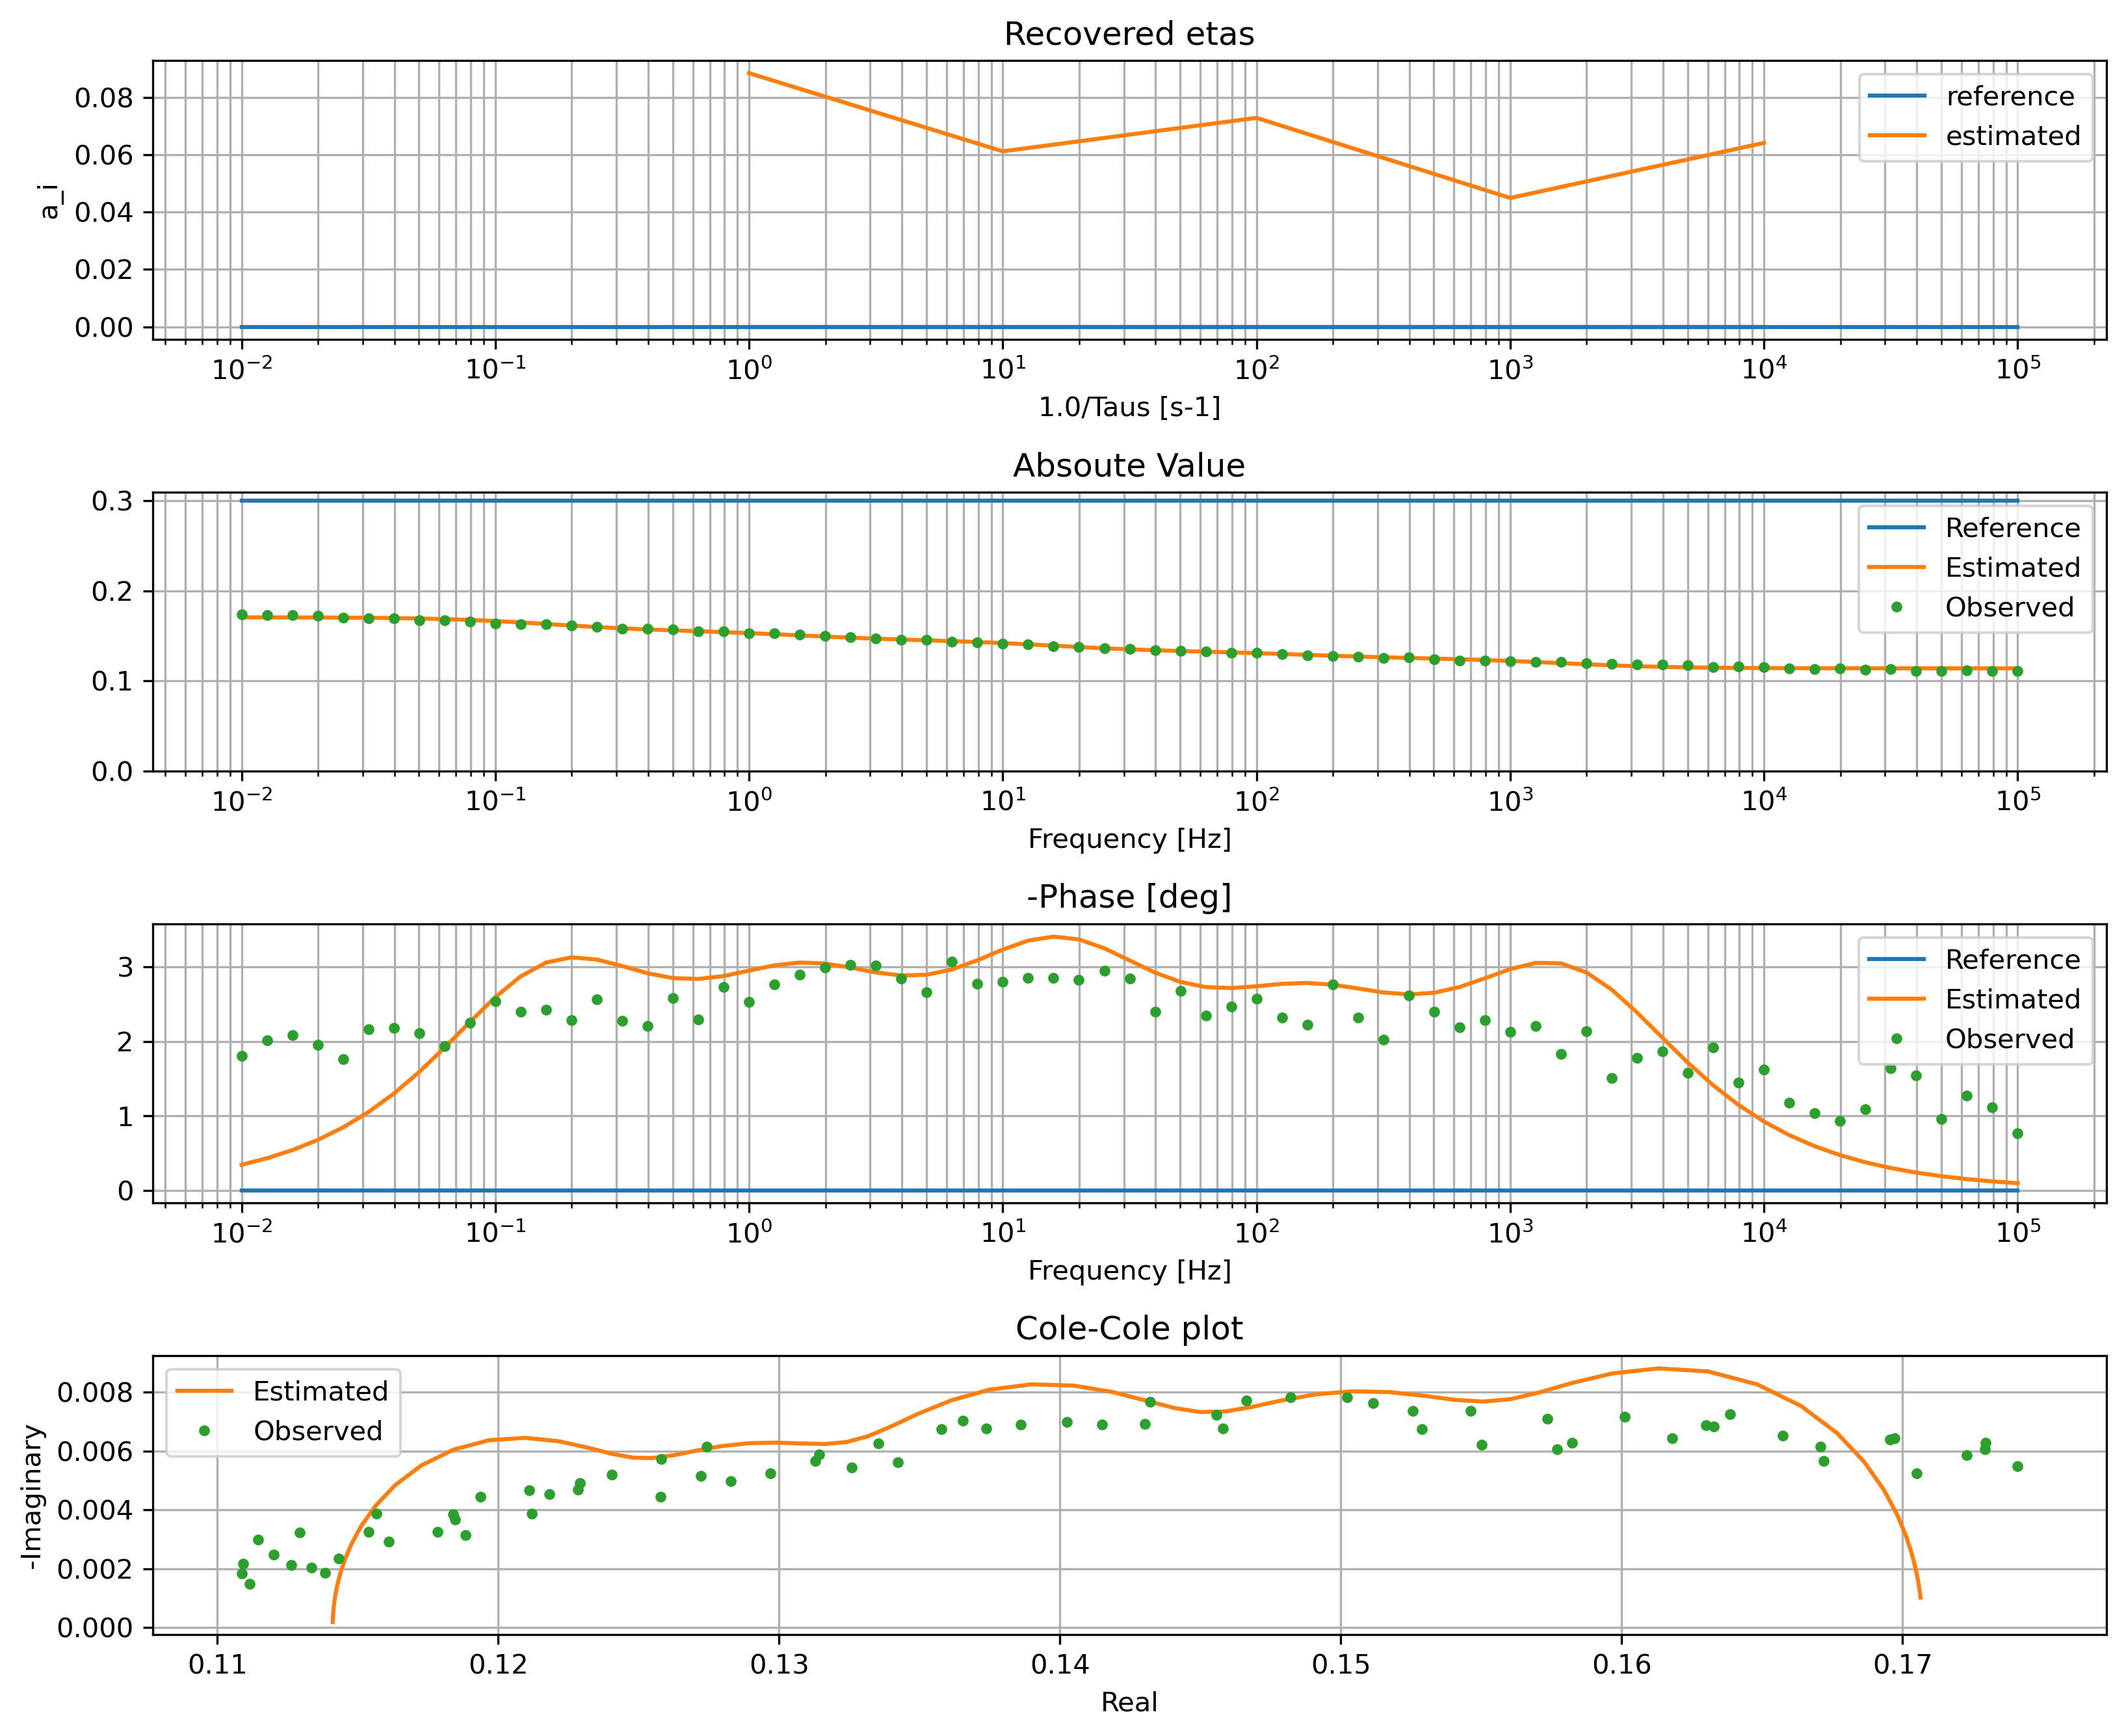

In [71]:
fig, ax = plt.subplots(4, 1, figsize=(11,9),dpi=300)

ax[0].semilogx(1/taus, mvec_init[1:1+ntau], color="C0", label="reference")
ax[0].semilogx(1/taus, mvec_pred[1:1+ntau], color="C1", label="estimated")
ax[0].semilogx(np.r_[freq_plot.min(),freq_plot.max()], np.r_[0,0])
ax[1].semilogx(freq_plot, dinit_abs, color="C0", label="Reference")
ax[1].semilogx(freq_plot, dest_abs, color="C1", label="Estimated")
ax[1].semilogx(freq_plot, dobs_abs, color="C2", linestyle="", marker=".", label="Observed")

ax[1].set_ylim(bottom=0)
ax[2].semilogx(freq_plot, -dinit_phase, color="C0", label="Reference")
ax[2].semilogx(freq_plot, -dest_phase, color="C1", label="Estimated")
ax[2].semilogx(freq_plot, -dobs_phase, color="C2", linestyle="", marker=".", label="Observed")
# ax[3].plot(dinit_real, -dest_imag, color="C0", label="Initial")
ax[3].plot(dest_real, -dest_imag, color="C1", label="Estimated")
ax[3].plot(dobs_real, -dobs_imag, color="C2", linestyle="", marker=".", label="Observed")

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_xlabel("1.0/Taus [s-1]")
ax[0].set_ylabel("a_i")
ax[0].set_title("Recovered etas")
ax[1].set_title('Absoute Value')
ax[2].set_title('-Phase [deg]')
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()

# L1norm Regularization

In [72]:
parm_init = torch.tensor(np.r_[np.log(0.3), np.zeros(ntau)],
    dtype=torch.float32, requires_grad=True
) 

In [73]:
IP_model = Pelton_debye_f(freq=freq, ntau=ntau, taus=taus)
sim = InducedPolarizationSimulation(ip_model=IP_model)
opt = Optimization(sim=sim, dobs=dobs)

In [74]:

Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))
beta0 = opt.BetaEstimate_byEig(mvec=parm_init, update_Wsen=True)

In [75]:
niter = 50
mpred = opt.GradientDescentL1reg(stol=stol,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0, update_Wsen=True,
    ELS=True, BLS=True)

  1, beta:6.5e+06, step:9.8e-04, gradient:1.9e+06,  f:3.3e+05
  2, beta:6.5e+06, step:9.8e-04, gradient:1.1e+07,  f:3.4e+05
  3, beta:3.3e+06, step:9.8e-04, gradient:5.8e+06,  f:3.3e+05
  4, beta:3.3e+06, step:3.1e-02, gradient:4.4e+06,  f:3.4e+05
  5, beta:1.6e+06, step:7.8e-03, gradient:3.0e+06,  f:3.3e+05
  6, beta:1.6e+06, step:2.5e-01, gradient:1.4e+06,  f:3.1e+05
  7, beta:8.2e+05, step:1.0e+00, gradient:4.2e+05,  f:3.0e+05
  8, beta:8.2e+05, step:1.0e+00, gradient:4.1e+05,  f:3.0e+05
  9, beta:4.1e+05, step:1.0e+00, gradient:8.4e+05,  f:2.2e+05
 10, beta:4.1e+05, step:1.0e+00, gradient:1.8e+05,  f:2.1e+05
 11, beta:2.0e+05, step:1.0e+00, gradient:4.9e+05,  f:1.3e+05
 12, beta:2.0e+05, step:1.0e+00, gradient:8.1e+04,  f:1.2e+05
 13, beta:1.0e+05, step:1.0e+00, gradient:2.2e+05,  f:7.2e+04
 14, beta:1.0e+05, step:1.0e+00, gradient:3.7e+04,  f:6.8e+04
 15, beta:5.1e+04, step:1.0e+00, gradient:1.2e+05,  f:3.8e+04
 16, beta:5.1e+04, step:1.0e+00, gradient:1.9e+04,  f:3.6e+04
 17, bet

In [76]:
opt.mvec_prg

[array([-1.2039728,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ], dtype=float32),
 array([-1.2041438e+00,  1.0000000e-03,  1.0000000e-03,  1.0000000e-03,
         1.0000000e-03,  1.0000000e-03], dtype=float32),
 array([-1.2033263e+00,  1.0000000e-03,  1.0000000e-03,  1.0000000e-03,
         1.0000000e-03,  1.0000000e-03], dtype=float32),
 array([-1.21001e+00,  1.00000e-03,  1.00000e-03,  1.00000e-03,
         1.00000e-03,  1.00000e-03], dtype=float32),
 array([-1.1993763e+00,  1.0000000e-03,  1.0000000e-03,  1.0000000e-03,
         1.0000000e-03,  1.0000000e-03], dtype=float32),
 array([-1.2315446e+00,  1.0000000e-03,  1.0000000e-03,  1.0000000e-03,
         1.0000000e-03,  1.0000000e-03], dtype=float32),
 array([-1.2062733e+00,  1.0000000e-03,  1.0000000e-03,  1.0000000e-03,
         1.0000000e-03,  1.0000000e-03], dtype=float32),
 array([-1.2720867e+00,  1.0000000e-03,  1.0000000e-03,  1.6160853e-02,
         3.3189390e-02,  4.9191635e-02], dtype=float32),
 arr

In [77]:
np_mvec_prg = opt.mvec_prg
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = opt.dpred(mpred)
mvec_pred_L1 = mpred.detach().numpy()
mvec_init = parm_init.detach().numpy()
#taus = np.exp(mvec_pred[1+ntau:])

In [78]:
print(f"initial :{np.exp(np_mvec_init[0]):.3e}, {np_mvec_init[1].sum():3f}")
print(f"est     :{np.exp(np_mvec_est[0]):.3e}, { np_mvec_est[1:].sum():3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.3e}, {np_mvec_true[1]:3f}, {np.exp(np_mvec_true[2]):.3e}, {np_mvec_true[3]:.3f}")


initial :3.000e-01, 0.000000
est     :1.708e-01, 0.331336
true    :2.000e-01, 0.500000, 1.000e-01, 0.200


In [79]:
nwindow = len(freq)
dest_real_L1 = dest[:nwindow].detach().numpy().flatten()
dest_imag_L1 = dest[nwindow:].detach().numpy().flatten()
dest_abs_L1 = np.abs(dest_real_L1+ 1.0j*dest_imag_L1)
dest_phase_L1 = np.angle(dest_real_L1+ 1.0j*dest_imag_L1, deg=True) # -1000*np.arctan2(dest_imag, dest_real)
# dobs_real = dobs[:nwindow].detach().numpy().flatten()
# dobs_imag = dobs[nwindow:].detach().numpy().flatten()
# dobs_abs = np.abs(dobs_real+ 1.0j*dobs_imag)
# dobs_phase = np.angle(dobs_real+ 1.0j*dobs_imag, deg=True) 
# dinit_real = dinit[:nwindow].detach().numpy().flatten()
# dinit_imag = dinit[nwindow:].detach().numpy().flatten()
# dinit_abs = np.abs(dinit_real+ 1.0j*dinit_imag)
# dinit_phase =  np.angle(dinit_real+ 1.0j*dinit_imag, deg=True)


In [80]:
mvec_pred

array([-1.7678455 ,  0.06412696,  0.04492385,  0.07285607,  0.06118991,
        0.08844993], dtype=float32)

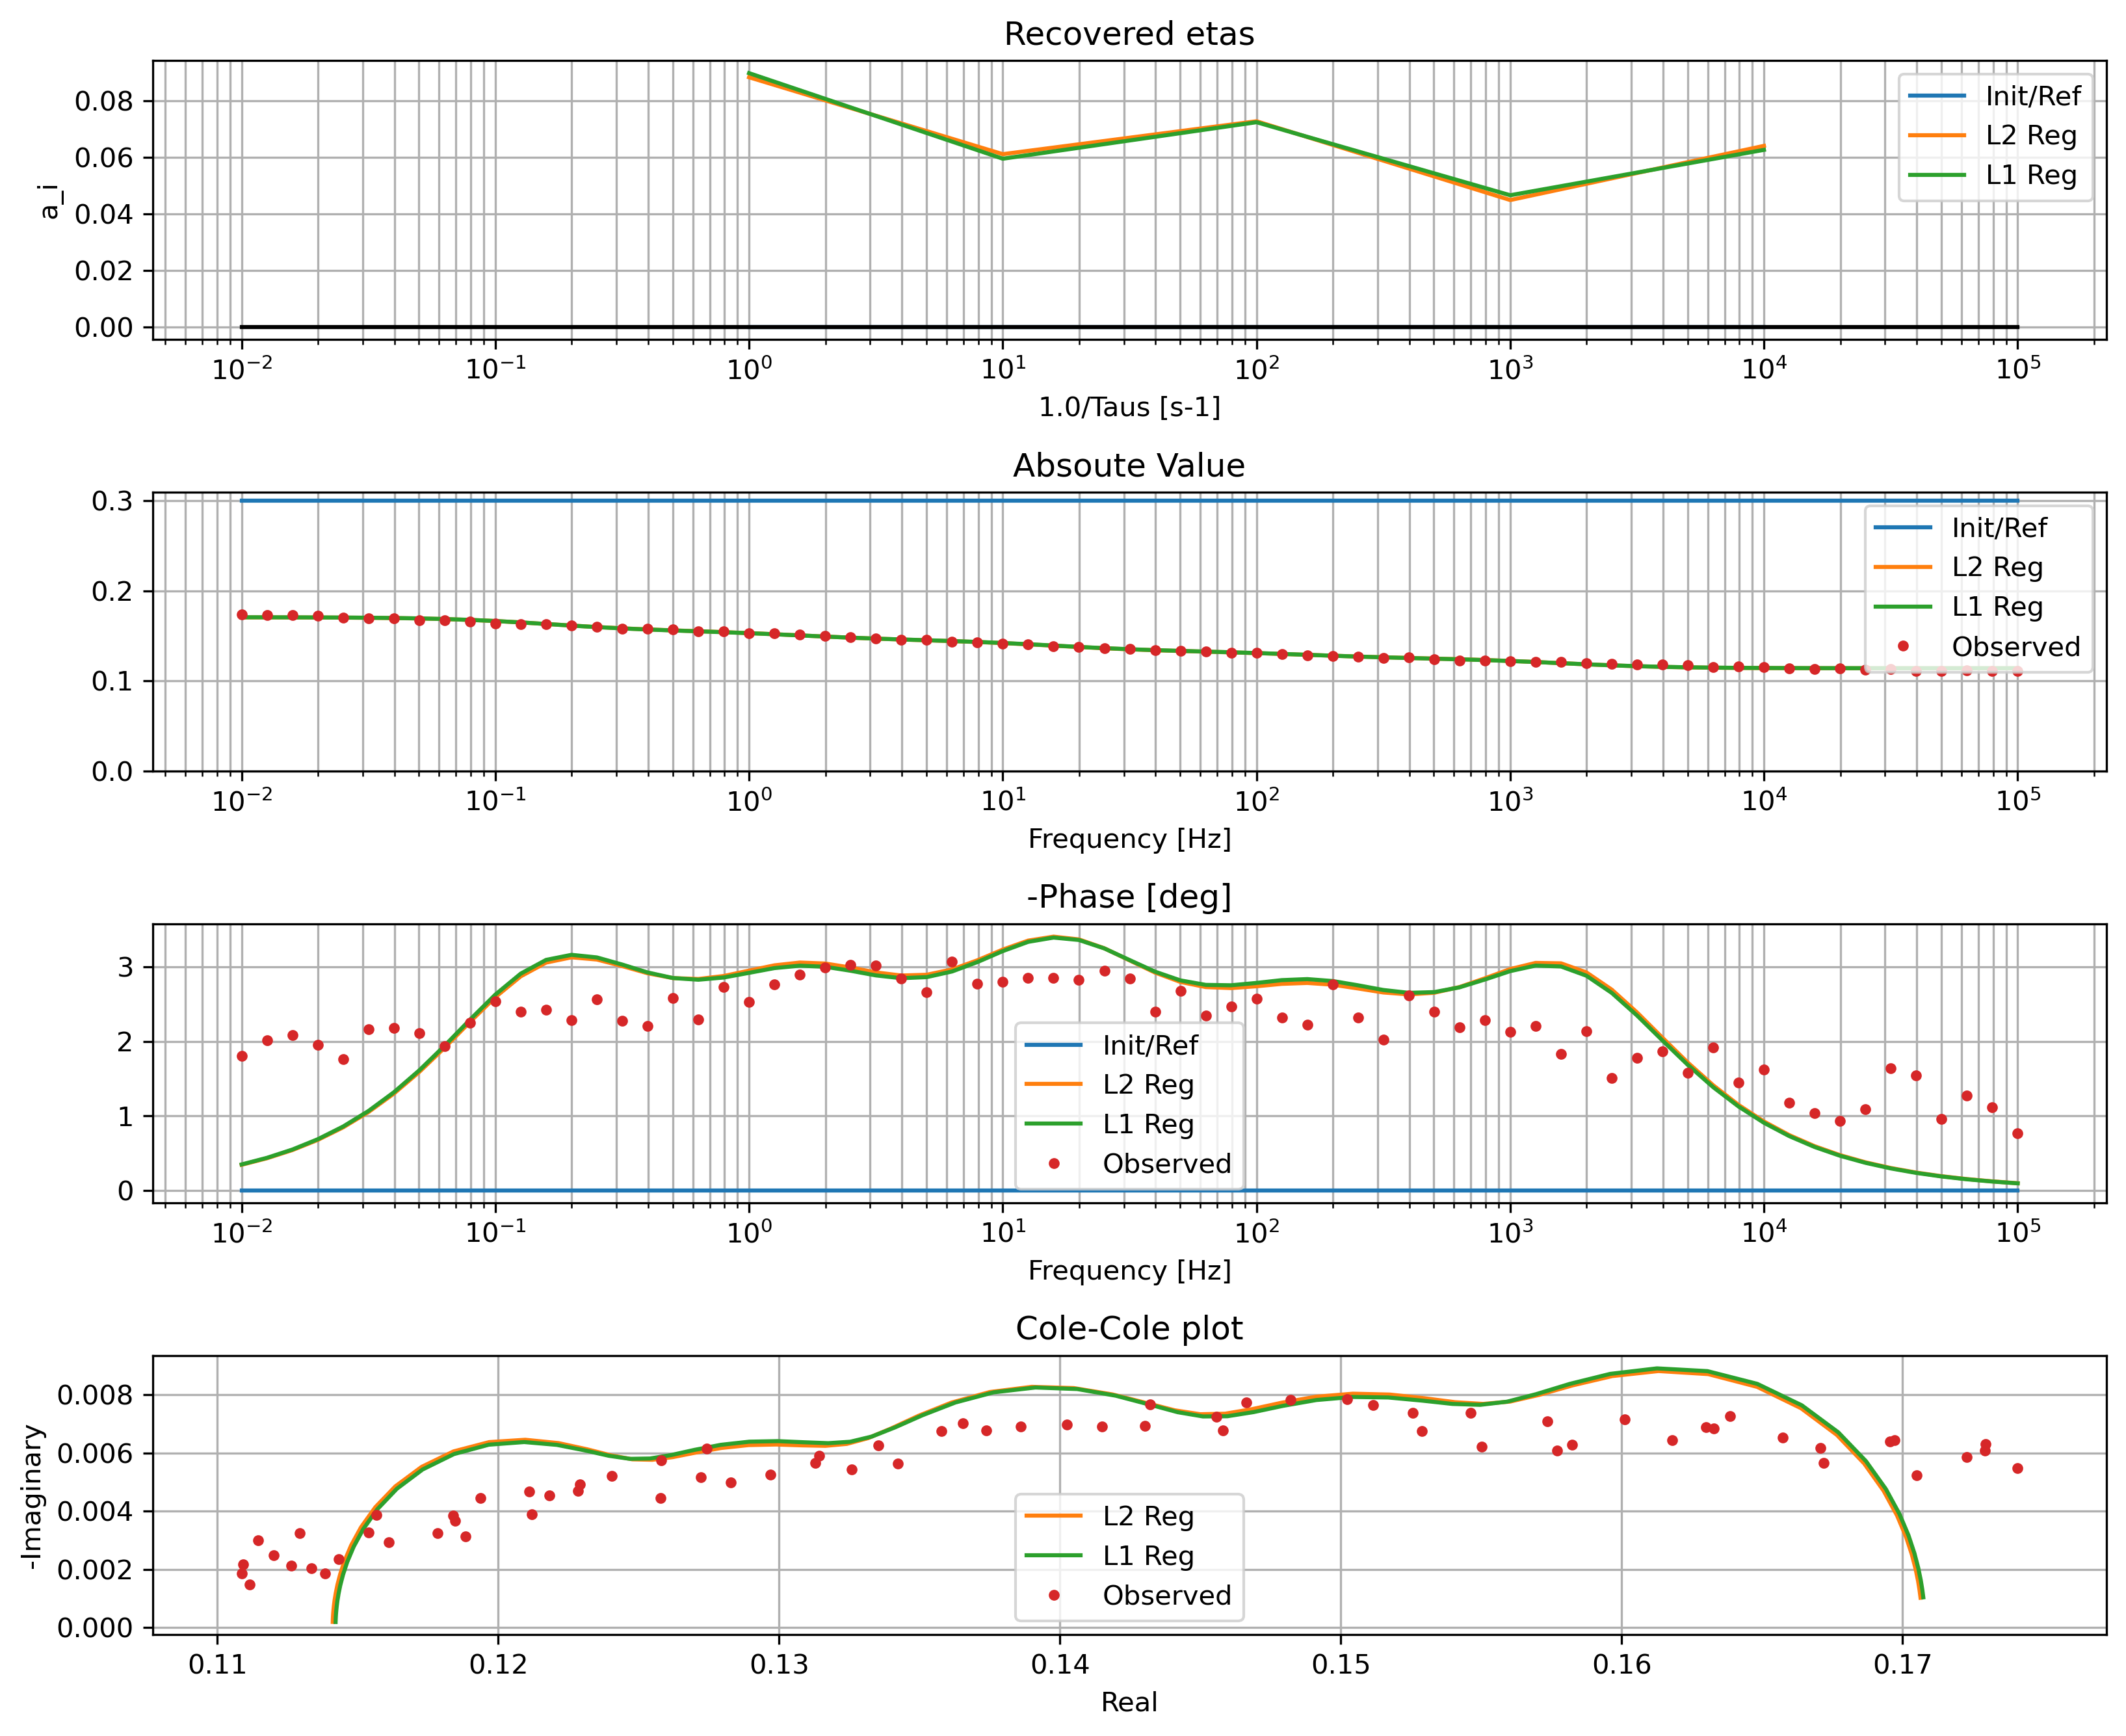

In [81]:
fig, ax = plt.subplots(4, 1, figsize=(11,9),dpi=300)

ax[0].semilogx(1/taus, mvec_init[1:1+ntau], color="C0", label="Init/Ref")
ax[0].semilogx(1/taus, mvec_pred[1:1+ntau], color="C1", label="L2 Reg")
ax[0].semilogx(1/taus, mvec_pred_L1[1:1+ntau], color="C2", label="L1 Reg")
ax[0].semilogx(np.r_[freq_plot.min(),freq_plot.max()], np.r_[0,0], color="k")

ax[1].semilogx(freq_plot, dinit_abs, color="C0", label="Init/Ref")
ax[1].semilogx(freq_plot, dest_abs, color="C1", label="L2 Reg")
ax[1].semilogx(freq_plot, dest_abs_L1, color="C2", label="L1 Reg")
ax[1].semilogx(freq_plot, dobs_abs, color="C3", linestyle="", marker=".", label="Observed")

ax[1].set_ylim(bottom=0)
ax[2].semilogx(freq_plot, -dinit_phase, color="C0", label="Init/Ref")
ax[2].semilogx(freq_plot, -dest_phase, color="C1", label="L2 Reg")
ax[2].semilogx(freq_plot, -dest_phase_L1, color="C2", label="L1 Reg")
ax[2].semilogx(freq_plot, -dobs_phase, color="C3", linestyle="", marker=".", label="Observed")
# ax[3].plot(dinit_real, -dest_imag, color="C0", label="Initial")
ax[3].plot(dest_real, -dest_imag, color="C1", label="L2 Reg")
ax[3].plot(dest_real_L1, -dest_imag_L1, color="C2", label="L1 Reg")
ax[3].plot(dobs_real, -dobs_imag, color="C3", linestyle="", marker=".", label="Observed")

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_xlabel("1.0/Taus [s-1]")
ax[0].set_ylabel("a_i")
ax[0].set_title("Recovered etas")
ax[1].set_title('Absoute Value')
ax[2].set_title('-Phase [deg]')
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()

In [82]:
d

NameError: name 'd' is not defined

In [ ]:
parm_init = torch.tensor(np.r_[np.log(0.3), np.zeros(ntau)], 
                dtype=torch.float32, requires_grad=True)
mvec_init=parm_init
mvec_prg = []
mvec_prg.append(mvec_init.detach().numpy())
print(mvec_init)

tensor([-1.2040,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       requires_grad=True)


In [ ]:
f, phid, phim = opt.loss_func_L1reg(m=mvec_init, beta=beta0, m_ref=parm_init)
print(f)
f.backward()


tensor(268262.0312, grad_fn=<AddBackward0>)


In [ ]:
g = parm_init.grad
print(g)
J = opt.J(parm_init)
A = opt.Wd @ J        
t = np.dot(g,g)/np.dot(A@g,A@g)
dm = t*g.flatten() 

tensor([ 914852.5000, -283768.0000, -437688.2812, -588617.6250, -720640.9375,
        -818390.1250])


In [ ]:
def loss_func_L1reg(m, beta, m_ref=None):
    r = opt.dpred(m)-opt.dobs
    r = opt.Wd @ r
    phid = 0.5 * torch.dot(r,r)
    phim = 0
    if m_ref is not None:
        rms = opt.Ws @ (m - m_ref)
        phim = opt.alphas*torch.sum(abs(rms))
    if opt.Wx is not None:
        rmx = opt.Wx @ m
        phim += opt.alphax*torch.sum(abs(rmx)) 
    return phid+beta*phim, phid, phim 

In [ ]:
parm_init = torch.tensor(np.r_[np.log(0.3), np.zeros(ntau)], 
                dtype=torch.float32, requires_grad=True)
mvec_init=parm_init.clone().detach().requires_grad_()
gtol=1e-3
mu=1e-4
ELS=True
BLS=True
mvec_old = mvec_init
udpate_Wsen =True
sfac= 0.5
s0 = 1.0
stol = 1e-6
m_ref = parm_init.detach()
f_old, phid, phim = loss_func_L1reg(mvec_old, beta=beta0, m_ref=m_ref)


In [ ]:

for i in range(niter):
# for i in range(niter):
    beta = beta0* torch.tensor(1.0 / (coolingFactor ** (i // coolingRate)))
    # Ensure mvec_old is ready for gradients
    # mvec_old = mvec_old.detach().requires_grad_()
    f_old, phid, phim = opt.loss_func_L1reg(mvec_old,beta=beta,m_ref=m_ref) 
    J = opt.J(mvec_old)
    if mvec_old.grad is not None:
        mvec_old.grad.zero_()
    f_old.backward()  # Compute the gradient of f_old
    g = mvec_old.grad  # Get the gradient of mvec_old
    # print(f'Gradient: {g}')

    # Exact line search
    if ELS:
        A = opt.Wd @ J             
        t = torch.dot(g,g)/torch.dot(A@g,A@g)
    else:
        t = 1.
    g_norm = torch.linalg.norm(g, ord=2)

    s = torch.tensor(s0)
    dm = t*g.flatten()  # Ensure dm is a 1D tensor
    mvec_new = opt.project_convex_set(mvec_old - s * dm)
    f_new, phid, phim = opt.loss_func_L1reg(mvec_new, beta=beta,m_ref=m_ref)
    directional_derivative = torch.dot(g.flatten(), -dm.flatten())
    if BLS:
        while f_new >= f_old + s*torch.tensor(mu)* directional_derivative:
            s *= torch.tensor(sfac)
            mvec_new = opt.project_convex_set(mvec_old - s * dm)
            f_new, phid, phim = opt.loss_func_L1reg(mvec_new,beta=beta,m_ref=m_ref) 
            if s < torch.tensor(stol):
                break
    mvec_old = mvec_new.detach().clone().requires_grad_()
    print(f'{i + 1:3}, beta:{beta:.1e}, step:{s:.1e}, gradient:{g_norm:.1e},  f:{f_new:.1e}')

  1, beta:5.1e+06, step:9.5e-07, gradient:1.6e+06,  f:2.9e+05
  2, beta:5.1e+06, step:9.5e-07, gradient:8.5e+06,  f:2.9e+05
  3, beta:2.5e+06, step:9.5e-07, gradient:4.4e+06,  f:2.8e+05
  4, beta:2.5e+06, step:1.5e-05, gradient:3.5e+06,  f:2.8e+05
  5, beta:1.3e+06, step:1.9e-06, gradient:2.1e+06,  f:2.7e+05
  6, beta:1.3e+06, step:2.4e-04, gradient:1.0e+06,  f:2.7e+05
  7, beta:6.4e+05, step:1.0e+00, gradient:4.8e+05,  f:2.5e+05
  8, beta:6.4e+05, step:1.0e+00, gradient:4.0e+05,  f:2.4e+05
  9, beta:3.2e+05, step:1.0e+00, gradient:5.7e+05,  f:1.7e+05
 10, beta:3.2e+05, step:1.0e+00, gradient:1.3e+05,  f:1.6e+05
 11, beta:1.6e+05, step:1.0e+00, gradient:3.6e+05,  f:1.0e+05
 12, beta:1.6e+05, step:1.0e+00, gradient:4.8e+04,  f:9.9e+04
 13, beta:7.9e+04, step:1.0e+00, gradient:1.9e+05,  f:5.5e+04
 14, beta:7.9e+04, step:1.0e+00, gradient:1.9e+04,  f:5.4e+04
 15, beta:4.0e+04, step:1.0e+00, gradient:9.1e+04,  f:2.9e+04
 16, beta:4.0e+04, step:1.0e+00, gradient:7.7e+03,  f:2.9e+04
 17, bet

In [ ]:
mvec_old

tensor([-1.6261,  0.0067,  0.0161,  0.1144,  0.2276,  0.1187],
       requires_grad=True)

In [ ]:
mvec_new

tensor([-1.6261,  0.0067,  0.0161,  0.1144,  0.2276,  0.1187],
       grad_fn=<IndexPutBackward0>)

In [ ]:
mvec_init=parm_init
mvec_prg = []
mvec_prg.append(mvec_init.detach().numpy())
print(mvec_init)

tensor([-1.2040,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       requires_grad=True)
